In [1]:
import sys
import re, os, path, csv
import glob

import numpy as np
import pandas as pd
from numpy import fft

import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from numpy import fft
from larch import io, Interpreter
mylarch = Interpreter()

sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

from frxas import time_domain, models, hdf5_io
import dynamic_XAS_visualization as dxas

%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\'
match_str = 'E*_EtaAlign_Ir.h5'
match_str_eta = 'E*_EtaAlign_Eta.h5'
all_files = glob.glob(os.path.join(direc,match_str))
all_files.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

all_files_eta = glob.glob(os.path.join(direc,match_str_eta))
all_files_eta.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

In [3]:
models_Ir, models_Eta = [], []
for file, file_eta in zip(all_files, all_files_eta):
    models_Ir.append(hdf5_io.load_time_domain_fit(file[:-3]))
    models_Eta.append(hdf5_io.load_time_domain_fit(file_eta[:-3]))
meta = np.genfromtxt('..\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\Energies_Iravgs.csv', delimiter=',',skip_header=1)
energies = meta[:,1]
Ir_avgs = meta[:,2]

In [4]:
models_Ir[83]

In [6]:
Irs, Etas, Vs, Ir_actual = [], [], [], []
for model_Ir, model_Eta, Ir_avg in zip(models_Ir, models_Eta, Ir_avgs):
    Ns = int(model_Ir.ndata/2)
    dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
    freq_in = model_Ir.userkws['freq_in']
    b = model_Ir.userkws['window_param']
    ti = np.linspace(0, dt*(Ns-1),num=Ns)
    Ns_wfm = int(1/freq_in/dt)
    Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
    Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
    window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
    ti = ti[:Ns_wfm]
    Irs.append(Ir[:Ns_wfm]/window[:Ns_wfm])
    Etas.append(Eta[:Ns_wfm]/window[:Ns_wfm])
    Ir_actual.append(Ir[:Ns_wfm]/window[:Ns_wfm] + Ir_avg)
Irs = np.array(Irs)
Etas = np.array(Etas)
Ir_actual = np.array(Ir_actual)

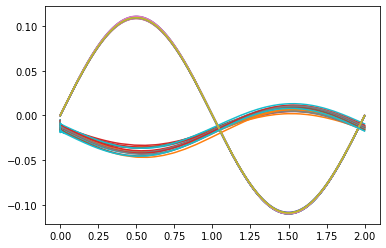

In [7]:
_, ax = plt.subplots()
maxes=[]
for (eta, Ir) in zip(Etas[70:90,:], Irs[70:90,:]):
    maxes.append(np.max(eta.real))
    ax.plot(ti, eta.real)
    ax.plot(ti, Ir.real)             

In [ ]:
_, ax1 = plt.subplots( figsize=(10,10))

for i in range(0, 40):
    ax1.plot(energies, Ir_actual[:,i*50].real, color=dxas.colorfun(Etas[0,i*50].real,np.max(np.abs(Etas[0,:].real))))
ax1.set_xlim(7718, 7721)
ax1.set_ylim(2.3,2.48)

In [ ]:
deglitch = [0,1,2,6,178,179]
energies[deglitch]
deglitch_mask = np.ones((len(energies)),dtype=bool)
deglitch_mask[:] = True
deglitch_mask[deglitch] = False

In [9]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\'
for i, (Ir,eta) in enumerate(zip(Ir_actual[deglitch_mask].T,Etas[0])):
#     print(np.shape(Ir[None].T), np.shape(energies[deglitch_mask,None]))
    svname = direc + f'{i} Eta {eta.real*1000:.2f} mV.txt'
    svdat = np.concatenate((energies[deglitch_mask, None], Ir[None].T.real), axis=1)
#     print(svname, svdat.shape, i)
#     np.savetxt(svname, svdat, delimiter='\t', fmt='%.8e')

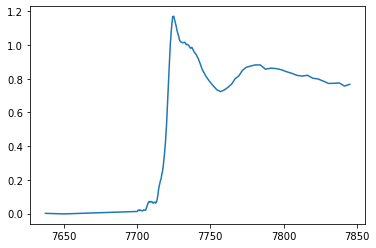

In [10]:
fname = 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\0.5 Hz Normalized.csv'

dat = np.array(pd.read_csv(fname, delimiter=',', header=None, skiprows=1))
energies_norm = dat[:,0]
Ir_norm = dat[:,1:]
Eta_norm = -Etas[0,::50].real

fig, ax = plt.subplots()
ax.plot(energies_norm, Ir_norm[:,0])
plt.show()

In [103]:
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
fig = dxas.plotXANES(energies_norm, Ir_norm[:,1:], Eta_norm[1:], startE=7700,stopE=7730,
               inset_dict=inset_dict, size=(9,6), marker='')
# plt.savefig(r'Plots\\0.5 Hz XANES Spectra.png', bbox_inches='tight', dpi=400)

NameError: name 'energies_norm' is not defined

(-0.05168025445675005, 0.014510811088712766)

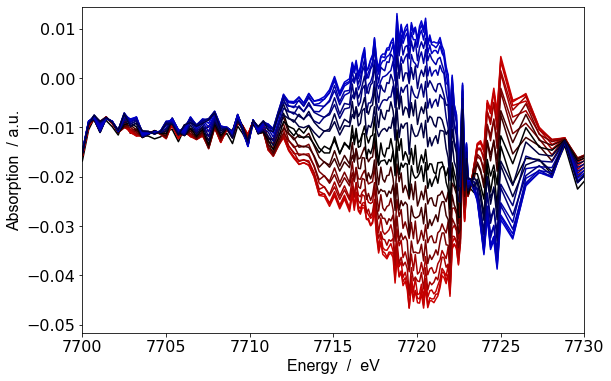

In [13]:
# Difference plot using unnormalized Ir
fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Irs[:,1::100].T.real):
    ax1.plot(energies,Ir, color=dxas.colorfun(Etas[0,n*100].real, np.max(np.abs(Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7730)
ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)

(7700.0, 7740.0)

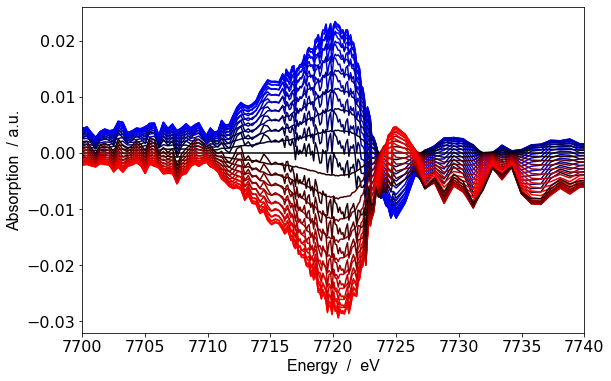

In [14]:
# Difference plot using normalized Ir
# Using Eta_norm[20] as OCV even though it's actually for +0.2 mV, since 
# Eta_norm[0] is making it look weird...

fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Ir_norm[:,1:].T):
    ax1.plot(energies_norm, Ir - Ir_norm[:,20], color=dxas.colorfun(Eta_norm[n+1], np.max(np.abs(Eta_norm))))# color=dxas.colorfun(-Etas[0,n*100].real, np.max(np.abs(-Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7740)
# ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)

## Normalize XANES spectra of first harmonic, deglitched data

## Run Feb18 XANES Normalization notebook before continuing

In [ ]:
dir_path = 'C:/Users/shadd/OneDrive/Documents/Python/Xray-project/fr_XAS/Feb2018 Data Fits/0.5 Hz XANES by Eta/Raw_All_Eta/'
all_files = glob.glob(dir_path + '*Eta*')
all_files.sort(key=lambda file: int(file.split('\\')[-1].split(' Eta')[0]))

In [ ]:
ath_prj = io.create_athena(r'0.5_Hz_all_eta.prj', _larch=mylarch)
for file in all_files:
    ath_prj.add_group(dxas.larch_xafs_normalization(file))
    
ath_prj.save()

In [8]:
norm_prj = io.read_athena(r'0.5_Hz_all_eta.prj', _larch=mylarch)

In [9]:
energies, mus, Ir_larch, Eta_larch = [], [], [], []
for name, group in norm_prj._athena_groups.items():
    energies.append(group.energy)
    Ir_larch.append(group.norm)
    Eta_larch.append(dxas.group_name_to_eta(name))
    mus.append(group.mu)

energies = dxas.transpose_list(energies)
Ir_larch = dxas.transpose_list(Ir_larch)
Eta_larch = dxas.transpose_list(Eta_larch) / 1000
mus = dxas.transpose_list(mus)

In [96]:
print(energies[:,0])

[7637.2   7649.699 7662.199 7687.331 7700.01  7700.388 7700.719 7701.071
 7701.434 7701.798 7702.155 7702.515 7702.879 7703.242 7703.6   7703.961
 7704.325 7704.687 7705.02  7705.381 7705.749 7706.112 7706.471 7706.831
 7707.196 7707.557 7707.915 7708.28  7708.646 7708.982 7709.29  7709.596
 7709.903 7710.211 7710.514 7710.823 7711.108 7711.416 7711.725 7712.029
 7712.333 7712.644 7712.953 7713.235 7713.538 7713.853 7714.161 7714.47
 7714.777 7715.077 7715.386 7715.67  7715.972 7716.137 7716.255 7716.367
 7716.499 7716.62  7716.733 7716.867 7716.988 7717.101 7717.233 7717.35
 7717.462 7717.592 7717.71  7717.842 7717.96  7718.074 7718.206 7718.328
 7718.441 7718.573 7718.693 7718.805 7718.936 7719.056 7719.168 7719.299
 7719.42  7719.535 7719.666 7719.788 7719.901 7720.034 7720.154 7720.267
 7720.397 7720.516 7720.646 7720.766 7720.879 7721.013 7721.133 7721.246
 7721.379 7721.5   7721.612 7721.744 7721.862 7721.974 7722.104 7722.226
 7722.358 7722.479 7722.593 7722.724 7722.846 7722.95

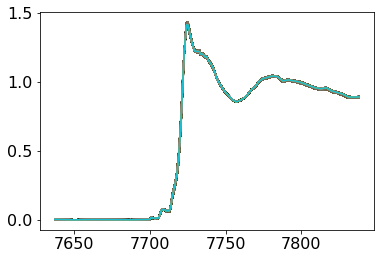

In [90]:
fig, ax = plt.subplots()
ax.plot(energies, Ir_larch)
plt.show()
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
# ax.set_xticklabels(['a','a','a'])  # xticks(np.arange(7700, 7800, step=10))

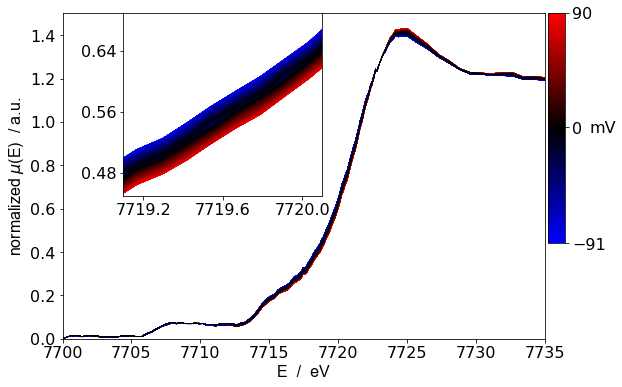

In [16]:
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
larch_step = 4
start_eta = 2
fig = dxas.plotXANES(energies[:, 0], Ir_larch[:,::larch_step], Eta_larch[::larch_step], startE=7700,stopE=7735,
               inset_dict=inset_dict, size=(9,6), marker='')
plt.savefig(r'Plots\\0.5 Hz XANES Spectra.png', bbox_inches='tight', dpi=400)

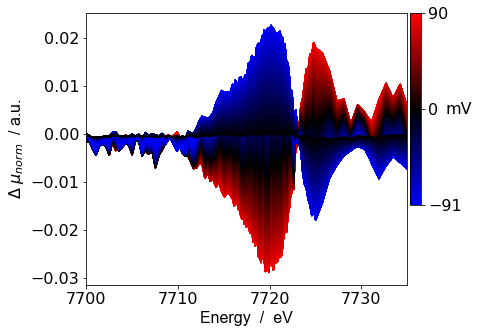

In [19]:
fig = dxas.plot_diffXANES(energies[:,0], Ir_larch, Eta_larch, start_eta, larch_step, size=(6,5))
plt.savefig(r'Plots\\0.5 Hz XANES Difference.png', bbox_inches='tight', dpi=400)
plt.show()

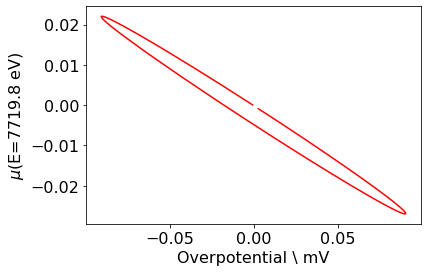

In [15]:
fig = dxas.plot_lissajou(energies, Ir_larch, Eta_larch, plot_e=7719.8, start_eta=2, larch_step=larch_step, color=(1,0,0))
plt.show()